# 高动态范围

### 目标
在本章中，我们将
- 了解如何根据曝光顺序生成和显示HDR图像。
- 使用曝光融合来合并曝光序列。

### 理论
高动态范围成像（HDRI或HDR）是一种用于成像和摄影的技术，可以比标准数字成像或摄影技术重现更大的动态亮度范围。虽然人眼可以适应各种光照条件，但是大多数成像设备每通道使用8位，因此我们仅限于256级。当我们拍摄现实世界的照片时，明亮的区域可能会曝光过度，而黑暗的区域可能会曝光不足，因此我们无法一次拍摄所有细节。HDR成像适用于每个通道使用8位以上（通常为32位浮点值）的图像，从而允许更大的动态范围。

获取HDR图像的方法有多种，但是最常见的一种方法是使用以不同曝光值拍摄的场景照片。要综合这些曝光，了解相机的响应功能以及估算算法的功能非常有用。合并HDR图像后，必须将其转换回8位才能在常规显示器上查看。此过程称为音调映射。当场景或摄像机的对象在两次拍摄之间移动时，还会增加其他复杂性，因为应记录并调整具有不同曝光度的图像。

在本教程中，我们展示了两种算法（Debevec，Robertson）来根据曝光序列生成和显示HDR图像，并演示了另一种称为曝光融合（Mertens）的方法，该方法可以生成低动态范围图像，并且不需要曝光时间数据。此外，我们估计相机响应函数（CRF）对于许多计算机视觉算法都具有重要价值。HDR流水线的每个步骤都可以使用不同的算法和参数来实现，因此请查看参考手册以了解所有内容。

### 曝光序列HDR
在本教程中，我们将查看以下场景，其中有4张曝光图像，曝光时间分别为15、2.5、1 / 4和1/30秒。 （你可以从Wikipedia下载图像）

**1. 将曝光图像加载到列表中**

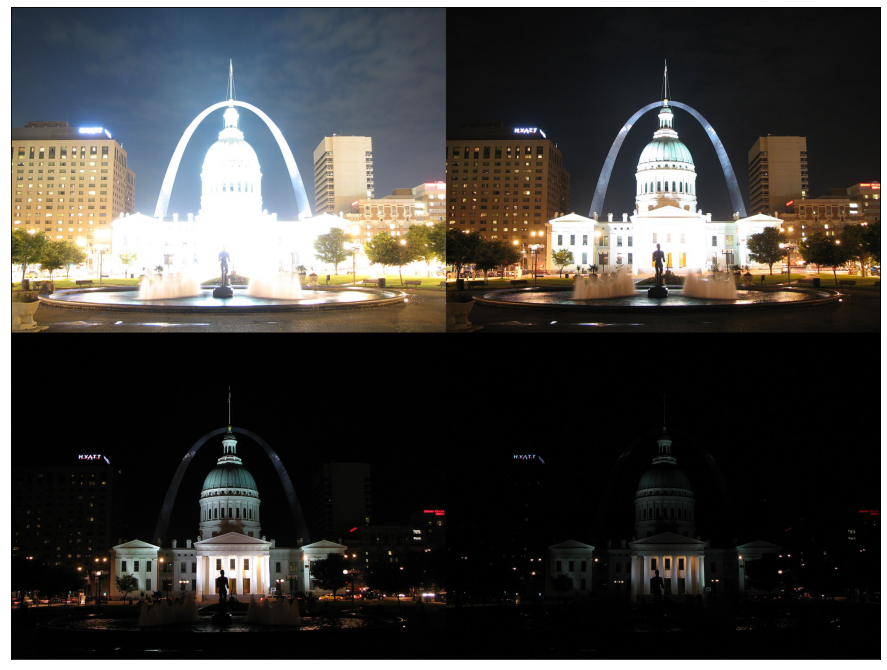

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 将曝光图像加载到列表中
img_fn = ["data/img0.jpg", "data/img1.jpg", "data/img2.jpg", "data/img3.jpg"]
img_list = [cv.imread(fn) for fn in img_fn]
exposure_times = np.array([15.0, 2.5, 0.25, 0.0333], dtype=np.float32)

line1 = np.hstack((img_list[0],img_list[1]))
line2 = np.hstack((img_list[2],img_list[3]))
res = np.vstack((line1,line2))

plt.figure(figsize=(16,12))
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

**2. 将曝光合成HDR图像**
在此阶段，我们将曝光序列合并为一张HDR图像，显示了OpenCV中的两种可能性。 第一种方法是Debevec，第二种方法是Robertson。 请注意，HDR图像的类型为float32，而不是uint8，因为它包含所有曝光图像的完整动态范围。

In [2]:
# 将曝光合成HDR图像
merge_debevec = cv.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy())

merge_robertson = cv.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())

**3. 色调图HDR图像**
我们将32位浮点HDR数据映射到[0..1]范围内。实际上，在某些情况下，该值可以大于1或小于0，因此请注意，我们稍后将必须裁剪数据以避免溢出。

In [3]:
# 色调图HDR图像
tonemap1 = cv.createTonemap(gamma=2.2)
res_debevec = tonemap1.process(hdr_debevec.copy())

tonemap2 = cv.createTonemap(gamma=2.2)
res_robertson = tonemap2.process(hdr_robertson.copy())

**4. 使用Mertens融合曝光**
在这里，我们展示了一种替代算法，用于合并曝光图像，而我们不需要曝光时间。我们也不需要使用任何色调映射算法，因为Mertens算法已经为我们提供了[0..1]范围内的结果。

In [4]:
# 使用Mertens融合曝光
merge_mertens = cv.createMergeMertens()
res_mertens = merge_mertens.process(img_list)

**5. 转为8-bit并保存**
为了保存或显示结果，我们需要将数据转换为[0..255]范围内的8位整数。

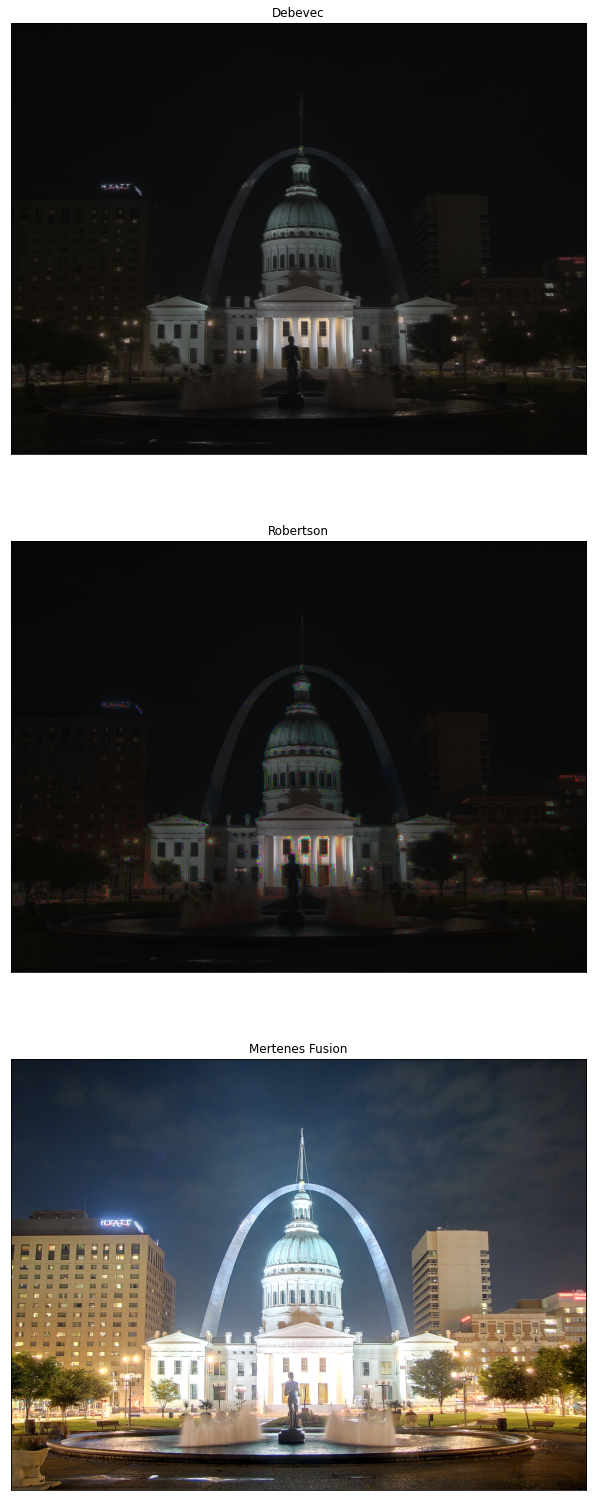

True

In [5]:
# 转化数据类型为8-bit并保存
res_debevec_8bit = np.clip(res_debevec*255, 0, 255).astype('uint8')
res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')

plt.figure(figsize=(12,27))

plt.subplot(311), plt.imshow(cv.cvtColor(res_debevec_8bit, cv.COLOR_BGR2RGB))
plt.title('Debevec')
plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(cv.cvtColor(res_robertson_8bit, cv.COLOR_BGR2RGB))
plt.title('Robertson')
plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(cv.cvtColor(res_mertens_8bit, cv.COLOR_BGR2RGB))
plt.title('Mertenes Fusion')
plt.xticks([]), plt.yticks([])

plt.show()

cv.imwrite("output/ldr_debevec.jpg", res_debevec_8bit)
cv.imwrite("output/ldr_robertson.jpg", res_robertson_8bit)
cv.imwrite("output/fusion_mertens.jpg", res_mertens_8bit)

### 结果
你可以看到不同的结果，但是请考虑到每种算法都有其他额外的参数，你应该将它们附加以达到期望的结果。 最佳实践是尝试不同的方法，然后看看哪种方法最适合你的场景。


### 估计相机响应函数
摄像机响应功能（CRF）使我们可以将场景辐射度与测量强度值联系起来。CRF在某些计算机视觉算法（包括HDR算法）中非常重要。在这里，我们估计逆相机响应函数并将其用于HDR合并。

In [6]:
# 估计相机响应函数(CRF)
cal_debevec = cv.createCalibrateDebevec()
crf_debevec = cal_debevec.process(img_list, times=exposure_times)
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy(), response=crf_debevec.copy())

cal_robertson = cv.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_list, times=exposure_times)
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy(), response=crf_robertson.copy())

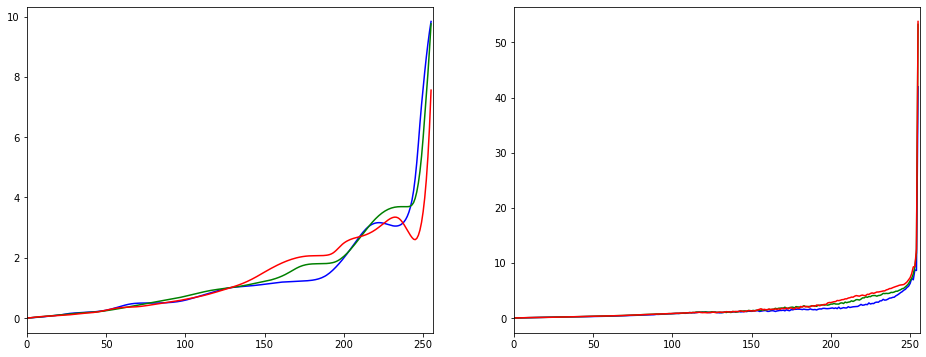

In [7]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(crf_debevec[:,0,0], 'b')
plt.plot(crf_debevec[:,0,1], 'g')
plt.plot(crf_debevec[:,0,2], 'r')
plt.xlim([0,256])

plt.subplot(122)
plt.plot(crf_robertson[:,0,0], 'b')
plt.plot(crf_robertson[:,0,1], 'g')
plt.plot(crf_robertson[:,0,2], 'r')
plt.xlim([0,256])

plt.show()

相机响应功能由每个颜色通道的256长度向量表示。 对于此序列，我们得到以下估计：

### 附加资源
1. Paul E Debevec and Jitendra Malik. Recovering high dynamic range radiance maps from photographs. In ACM SIGGRAPH 2008 classes, page 31. ACM, 2008. [48]
2. Mark A Robertson, Sean Borman, and Robert L Stevenson. Dynamic range improvement through multiple exposures. In Image Processing, 1999. ICIP 99. Proceedings. 1999 International Conference on, volume 3, pages 159–163. IEEE, 1999. [182]
3. Tom Mertens, Jan Kautz, and Frank Van Reeth. Exposure fusion. In Computer Graphics and Applications, 2007. PG'07. 15th Pacific Conference on, pages 382–390. IEEE, 2007. [148]
4. Images from Wikipedia-HDR

### 练习
1. 尝试所有色调图算法：cv::TonemapDrago,cv::TonemapMantiuk和cv::TonemapReinhard
2. 尝试更改HDR校准和色调图方法中的参数。